# Pump it Up: Data Mining the Water Table

## Introduction

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

## Objectives
- create a classifier
- clasify faulty pumps

## Tabel of contents

1. Import Datra
2. Data Analysis
    - 2.1 X_train & y_train info

## 1. Import Data
- import all the necessary classes, functions, and packages

In [50]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [5]:
df_values = pd.read_csv('Water_Table_Training_set_values.csv')
df_labels = pd.read_csv('Water_Table_Training_set_labels.csv')

In [35]:
with open('X_processed.pickle', 'rb') as f:
    X = pickle.load(f)
y = df_labels.drop('id', axis=1)

## 2. Data Analysis

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

In [3]:
#Check if id columns in both datasets match
(df_values['id'] == df_labels['id']).sum()

59400

In [5]:
y['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [37]:
# Convert y labels
y[y['status_group']=='non functional'] = 0
y[y['status_group']=='functional'] = 1
y[y['status_group']=='functional needs repair'] = 2

In [38]:
y['status_group'] = y['status_group'].astype(int)

In [39]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   status_group  59400 non-null  int64
dtypes: int64(1)
memory usage: 464.2 KB


In [40]:
X.drop(columns=['date_recorded', 'installer', 'funder', 'wpt_name', 'subvillage', 'ward', 'lga', 'scheme_name'], 
             axis=1,
            inplace=True)

In [41]:
object_X = X.select_dtypes(include ='object').columns
X = pd.get_dummies(X, columns=object_X)
X

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin_Internal,...,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999.0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,1399,34.698766,-2.147466,0,20,2,280,2010.0,0,...,0,0,0,0,0,1,0,0,0,0
2,25.0,686,37.460664,-3.821329,0,21,4,250,2009.0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,0,90,63,58,1986.0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0,31.130847,-1.825359,0,18,1,0,NaN,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,37.169807,-3.253847,0,3,5,125,1999.0,0,...,0,0,0,0,0,1,0,0,0,0
59396,4700.0,1212,35.249991,-9.070629,0,11,4,56,1996.0,0,...,0,0,0,0,0,1,0,0,0,0
59397,0.0,0,34.017087,-8.750434,0,12,7,0,NaN,0,...,0,1,0,0,0,0,0,1,0,0
59398,0.0,0,35.861315,-6.378573,0,1,4,0,NaN,0,...,0,1,0,0,0,0,0,1,0,0


In [42]:
X = pd.get_dummies(X, columns=['region_code', 'district_code'])
X

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,...,district_code_23,district_code_30,district_code_33,district_code_43,district_code_53,district_code_60,district_code_62,district_code_63,district_code_67,district_code_80
0,6000.0,1390,34.938093,-9.856322,0,109,1999.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1399,34.698766,-2.147466,0,280,2010.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25.0,686,37.460664,-3.821329,0,250,2009.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,263,38.486161,-11.155298,0,58,1986.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,0,31.130847,-1.825359,0,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,37.169807,-3.253847,0,125,1999.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59396,4700.0,1212,35.249991,-9.070629,0,56,1996.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59397,0.0,0,34.017087,-8.750434,0,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59398,0.0,0,35.861315,-6.378573,0,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [44]:
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_X_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
scaled_X_train

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,...,district_code_23,district_code_30,district_code_33,district_code_43,district_code_53,district_code_60,district_code_62,district_code_63,district_code_67,district_code_80
0,-0.093074,-0.487869,1.160517,-0.101385,-0.037802,-0.209732,-1.992842,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
1,-0.099150,-0.964042,-0.654989,0.993996,-0.037802,-0.379567,NaN,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
2,-0.099150,-0.964042,-0.694873,1.062603,-0.037802,-0.379567,NaN,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
3,-0.099150,1.260983,-0.127739,0.341389,-0.037802,-0.330739,1.056621,2.572798,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
4,-0.099150,-0.209380,-0.174825,-1.744463,-0.037802,-0.377444,1.297368,-0.388682,3.302814,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44545,0.204654,-0.492198,0.483098,-1.057184,-0.037802,0.161782,-0.147114,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
44546,0.204654,1.551016,-0.224731,-1.410979,-0.037802,-0.305264,-0.708858,-0.388682,3.302814,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
44547,-0.099150,-0.982800,1.488512,0.135575,-0.037802,1.743370,0.655376,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
44548,-0.099150,-0.964042,-0.307614,0.958382,-0.037802,-0.379567,NaN,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606


In [45]:
# This will transform the selected columns and merge to the original data frame
scaled_X_test = pd.DataFrame(scaled_data_test, columns=X_test.columns)
scaled_X_test

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,...,district_code_23,district_code_30,district_code_33,district_code_43,district_code_53,district_code_60,district_code_62,district_code_63,district_code_67,district_code_80
0,-0.099150,-0.964042,-1.206453,0.784408,-0.037802,-0.379567,NaN,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
1,-0.099150,-0.964042,-0.879777,0.304814,-0.037802,-0.379567,NaN,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
2,-0.096112,1.452895,0.144212,0.554783,-0.037802,-0.065372,0.896123,2.572798,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
3,-0.099150,-0.964042,-0.761003,-1.158405,-0.037802,-0.379567,NaN,-0.388682,-0.302772,4.781403,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
4,-0.083959,0.636187,-0.345986,0.487753,-0.037802,0.119323,1.136870,2.572798,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,-0.099150,-0.964042,-0.897673,0.894645,-0.037802,-0.379567,NaN,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
14846,0.052752,0.334611,0.603398,-1.125002,-0.037802,-0.356215,-1.350850,-0.388682,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
14847,-0.099150,0.620315,-1.491640,-0.198722,-0.037802,0.681901,0.896123,-0.388682,-0.302772,4.781403,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606
14848,-0.099150,-0.964042,-0.392128,0.941095,-0.037802,-0.379567,NaN,2.572798,-0.302772,-0.209144,...,-0.072665,-0.130412,-0.121491,-0.092507,-0.11465,-0.034185,-0.043722,-0.057734,-0.008206,-0.011606


In [ ]:
# Columns to drop
# 'date_recorded', 'funder', 'wpt_name', 'subvillage', 'ward', 'lga', 'scheme_name'

In [19]:
clf = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 6, min_child_weight = 10, n_estimators = 250, subsample = 0.7)

clf.fit(scaled_X_train, y_train)
training_preds = clf.predict(scaled_X_train)
val_preds = clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

# Training Accuracy: 82.07%
# Validation accuracy: 79.23%

Training Accuracy: 82.01%
Validation accuracy: 79.16%


In [21]:
cm = confusion_matrix(y_test, val_preds)
print(cm)

[[4115 1517   46]
 [ 635 7368   95]
 [ 167  634  273]]


In [46]:
param_grid = {
    "learning_rate": [0.2],
    'max_depth': [3, 6],
    'min_child_weight': [10],
    'subsample': [0.5, 0.7],
    'n_estimators': [250, 350],
}

In [47]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

# Grid Search found the following optimal parameters: 
# learning_rate: 0.2
# max_depth: 6
# min_child_weight: 10
# n_estimators: 350
# subsample: 0.7

# Training Accuracy: 86.23%
# Validation accuracy: 80.24%

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 10
n_estimators: 350
subsample: 0.7

Training Accuracy: 86.23%
Validation accuracy: 80.24%


In [49]:
cm = confusion_matrix(y_test, val_preds)
print(cm)

[[4292 1309   77]
 [ 667 7280  151]
 [ 156  575  343]]


In [53]:
print(classification_report(y_test, val_preds))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      5678
           1       0.79      0.90      0.84      8098
           2       0.60      0.32      0.42      1074

    accuracy                           0.80     14850
   macro avg       0.74      0.66      0.69     14850
weighted avg       0.80      0.80      0.79     14850



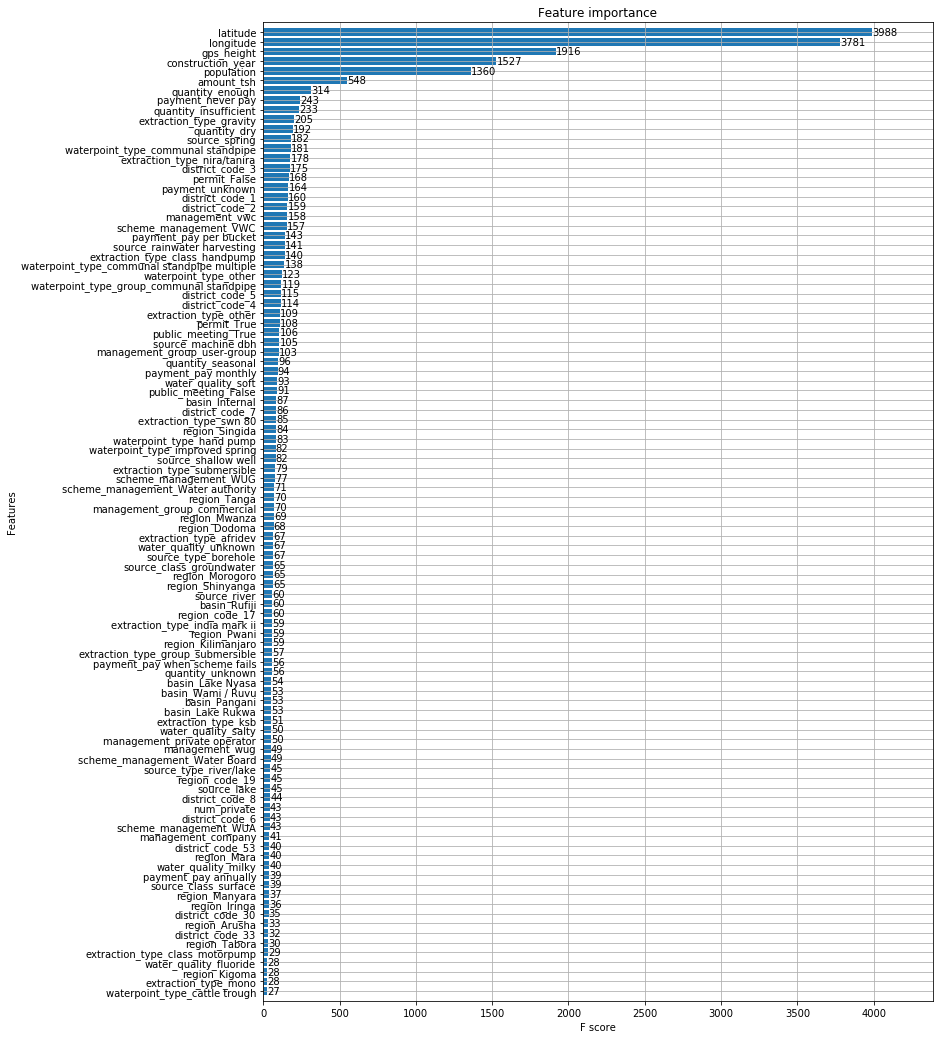

In [48]:
# importance_type (str, default "weight") – How the importance is calculated: either "weight", "gain", or "cover"

# "weight" is the number of times a feature appears in a tree
# "gain" is the average gain of splits which use the feature
# "cover" is the average coverage of splits which use the feature where coverage is defined as the 
# number of samples affected by the split

fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf, max_num_features=100, height=0.8, ax=ax)
plt.show()